In [3]:
import sys; print(sys.version)

3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]


In [4]:
!pip install --upgrade pip

     ---------------------------------------- 1.8/1.8 MB 7.8 MB/s eta 0:00:00


ERROR: To modify pip, please run the following command:
C:\Users\avane\Desktop\brain_tumor_detection_CNN\myenv-311\Scripts\python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
!pip install tensorflow

     -------------------------------------- 375.9/375.9 MB 7.1 MB/s eta 0:00:00
     -------------------------------------- 135.6/135.6 kB 7.8 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB ? eta 0:00:00
     --------------------------------------- 26.4/26.4 MB 16.8 MB/s eta 0:00:00
     ---------------------------------------- 71.9/71.9 kB 3.9 MB/s eta 0:00:00
     ------------------------------------- 434.5/434.5 kB 26.5 MB/s eta 0:00:00
     ---------------------------------------- 4.3/4.3 MB 12.4 MB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 16.0 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 17.1 MB/s eta 0:00:00
     --------------------------------------- 12.9/12.9 MB 19.2 MB/s eta 0:00:00
     ---------------------------------------- 3.0/3.0 MB 21.1 MB/s eta 0:00:00
     ------------------------------------- 209.7/209.7 kB 12.5 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1


[notice] A new release of pip available: 22.3 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from IPython.display import clear_output
!pip install kaggle imutils plotly opencv-python matplotlib scikit-learn
clear_output()

In [7]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

# from keras.preprocessing.image import ImageDataGenerator
# from keras.applications.vgg16 import VGG16, preprocess_input
# from keras import layers
# from keras.models import Model, Sequential
# from keras.optimizers import Adam, RMSprop
# from keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping


init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [8]:
import zipfile

# Download datasets
!kaggle datasets download -d gaborfodor/keras-pretrained-models
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

# Unzip the datasets
with zipfile.ZipFile("keras-pretrained-models.zip", 'r') as zip_ref:
    zip_ref.extractall("keras_pretrained_models")

with zipfile.ZipFile("brain-mri-images-for-brain-tumor-detection.zip", 'r') as zip_ref:
    zip_ref.extractall("brain_mri_images")

print("Data source import complete.")


Dataset URL: https://www.kaggle.com/datasets/gaborfodor/keras-pretrained-models
License(s): CC-BY-SA-4.0
keras-pretrained-models.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
Data source import complete.


In [9]:
import os

# Create folders
folders = [
    'TRAIN/YES', 'TRAIN/NO',
    'TEST/YES', 'TEST/NO',
    'VAL/YES', 'VAL/NO'
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

# Display folder tree
print("\nFolder structure:")
for root, dirs, files in os.walk(".", topdown=True):
    for name in dirs:
        print(os.path.join(root, name))



Folder structure:
.\.git
.\.ipynb_checkpoints
.\brain_mri_images
.\brain_tumor_dataset
.\keras_pretrained_models
.\myenv-311
.\no
.\TEST
.\TRAIN
.\VAL
.\venv
.\yes
.\.git\hooks
.\.git\info
.\.git\logs
.\.git\objects
.\.git\refs
.\.git\logs\refs
.\.git\logs\refs\heads
.\.git\logs\refs\remotes
.\.git\logs\refs\remotes\origin
.\.git\objects\23
.\.git\objects\45
.\.git\objects\47
.\.git\objects\59
.\.git\objects\6a
.\.git\objects\6c
.\.git\objects\9e
.\.git\objects\aa
.\.git\objects\d4
.\.git\objects\e0
.\.git\objects\info
.\.git\objects\pack
.\.git\refs\heads
.\.git\refs\remotes
.\.git\refs\tags
.\.git\refs\remotes\origin
.\brain_mri_images\brain_tumor_dataset
.\brain_mri_images\no
.\brain_mri_images\yes
.\brain_mri_images\brain_tumor_dataset\no
.\brain_mri_images\brain_tumor_dataset\yes
.\brain_tumor_dataset\no
.\brain_tumor_dataset\yes
.\myenv-311\etc
.\myenv-311\Include
.\myenv-311\Lib
.\myenv-311\Scripts
.\myenv-311\share
.\myenv-311\etc\jupyter
.\myenv-311\etc\jupyter\jupyter_notebo

In [10]:
import shutil
IMG_PATH = './brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [13]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(os.path.join(dir_path, path)):
                if not file.startswith('.'):
                    img = cv2.imread(os.path.join(dir_path, path, file))
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        X.append(img)
                        y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [14]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


193 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 33.85it/s]


10 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

50 images loaded from VAL/ directory.


In [15]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [16]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

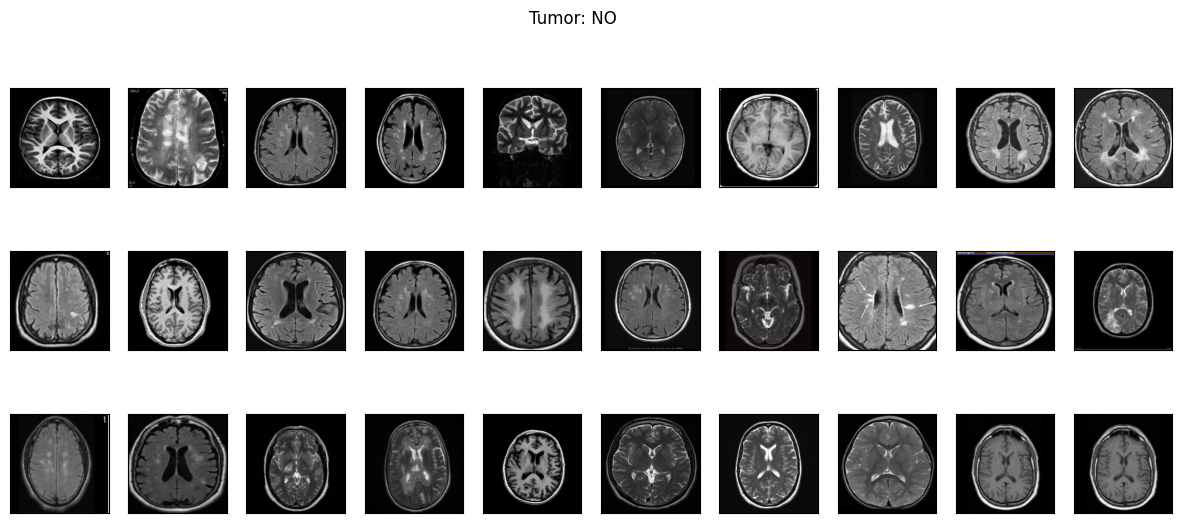

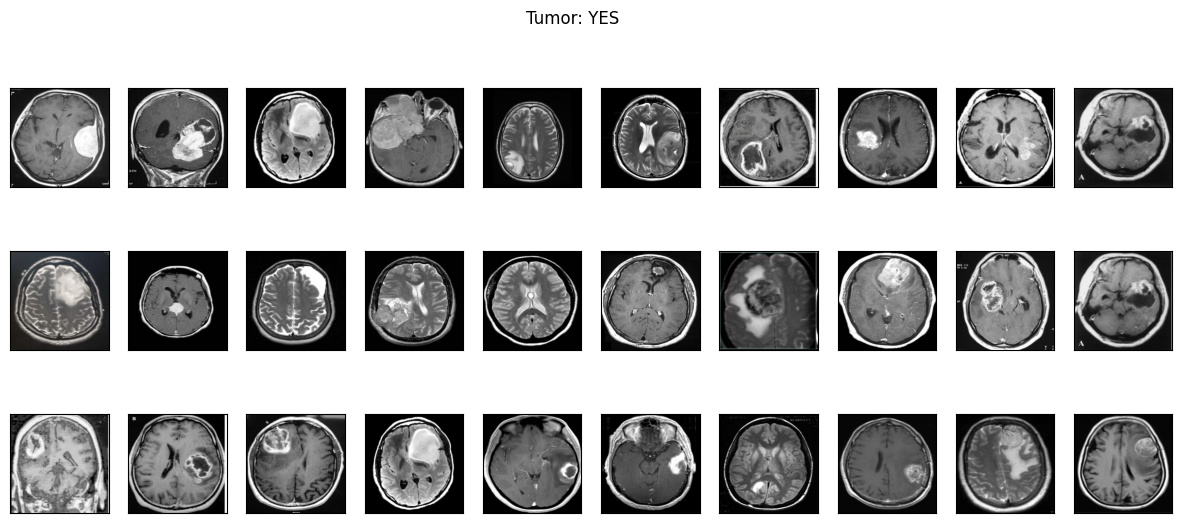

In [17]:
plot_samples(X_train, y_train, labels, 30)

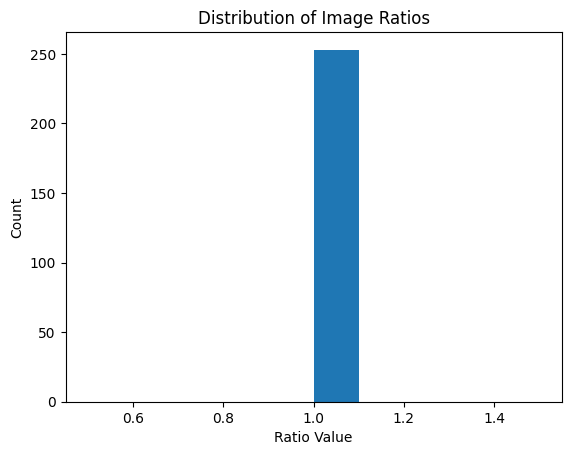

In [18]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])

plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [28]:
# def crop_imgs(set_name, add_pixels_value=0):
#     """
#     Finds the extreme points on the image and crops the rectangular out of them
#     """
#     set_new = []
#     for img in set_name:
#         gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         gray = cv2.GaussianBlur(gray, (5, 5), 0)

#         # threshold the image, then perform a series of erosions +
#         # dilations to remove any small regions of noise
#         thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
#         thresh = cv2.erode(thresh, None, iterations=2)
#         thresh = cv2.dilate(thresh, None, iterations=2)

#         # find contours in thresholded image, then grab the largest one
#         cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         cnts = imutils.grab_contours(cnts)
#         c = max(cnts, key=cv2.contourArea)

#         # find the extreme points
#         extLeft = tuple(c[c[:, :, 0].argmin()][0])
#         extRight = tuple(c[c[:, :, 0].argmax()][0])
#         extTop = tuple(c[c[:, :, 1].argmin()][0])
#         extBot = tuple(c[c[:, :, 1].argmax()][0])

#         ADD_PIXELS = add_pixels_value
#         new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
#         set_new.append(new_img)

#     return np.array(set_new)

def crop_imgs(set_name, add_pixels_value=0, final_size=(224,224)):
    set_new = []
    
    for img in tqdm(set_name):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        
        if len(cnts) == 0:
            # if no contours found, skip this image
            continue

        c = max(cnts, key=cv2.contourArea)

        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        cropped = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

        cropped_resized = cv2.resize(cropped, final_size, interpolation=cv2.INTER_AREA)
        set_new.append(cropped_resized)

    return np.array(set_new)


In [29]:
img = cv2.imread('./brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

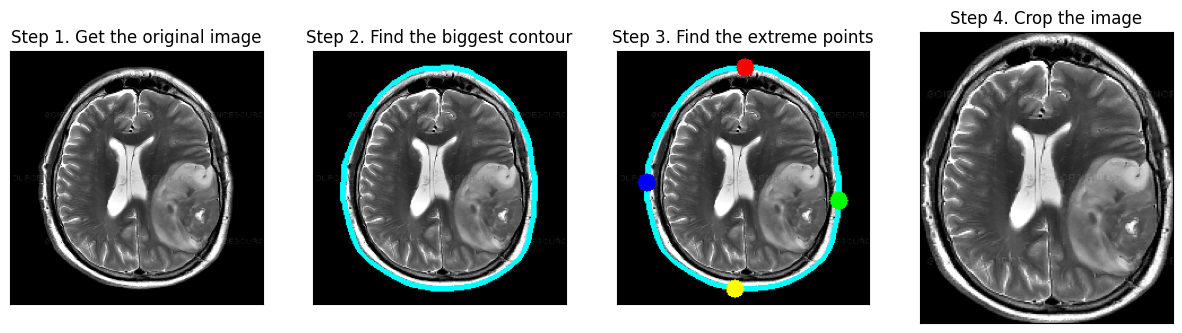

In [30]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [31]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

100%|██████████| 10/10 [00:00<00:00, 1810.07it/s]


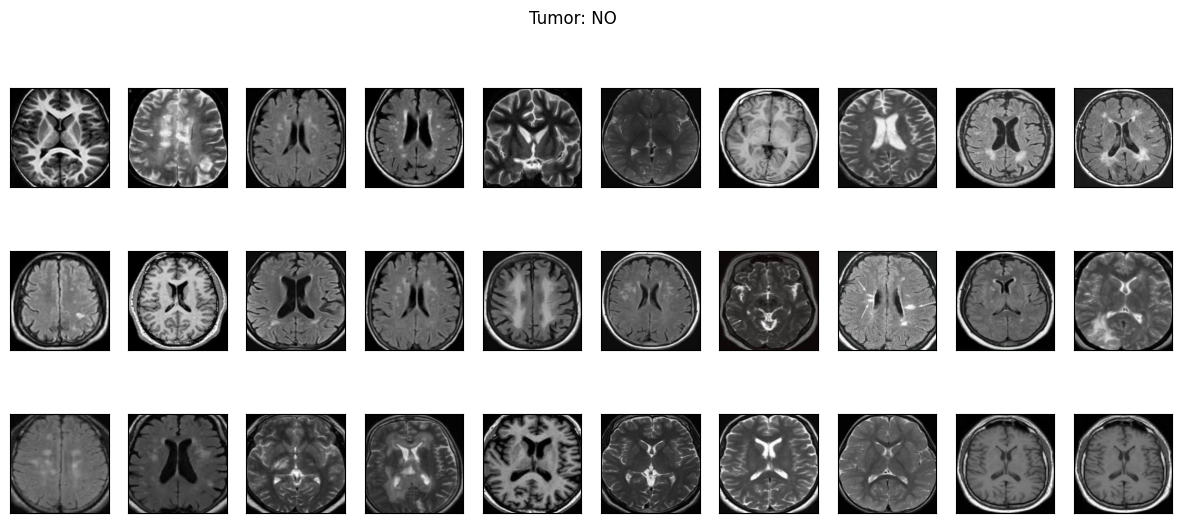

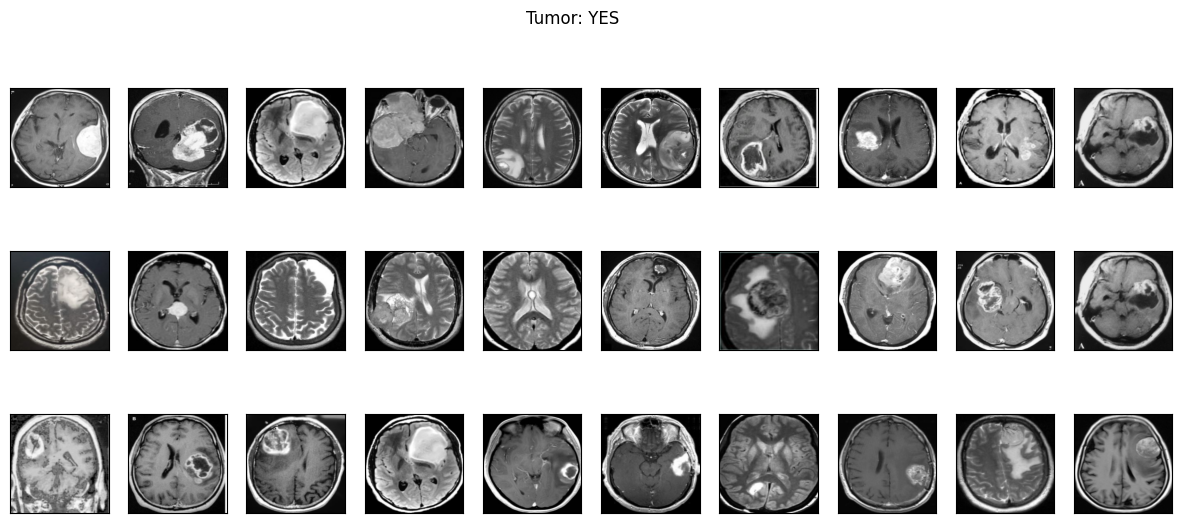

In [32]:
plot_samples(X_train_crop, y_train, labels, 30)

In [33]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [35]:
# saving new images to the folder
import os

# List of folders you want to create
folders = [
    'TRAIN_CROP/YES', 'TRAIN_CROP/NO',
    'TEST_CROP/YES', 'TEST_CROP/NO',
    'VAL_CROP/YES', 'VAL_CROP/NO'
]

# Create each folder if it doesn't exist
for folder in folders:
    os.makedirs(folder, exist_ok=True)


save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [36]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [37]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..149.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..142.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..133.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..150.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..150.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..126.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data 

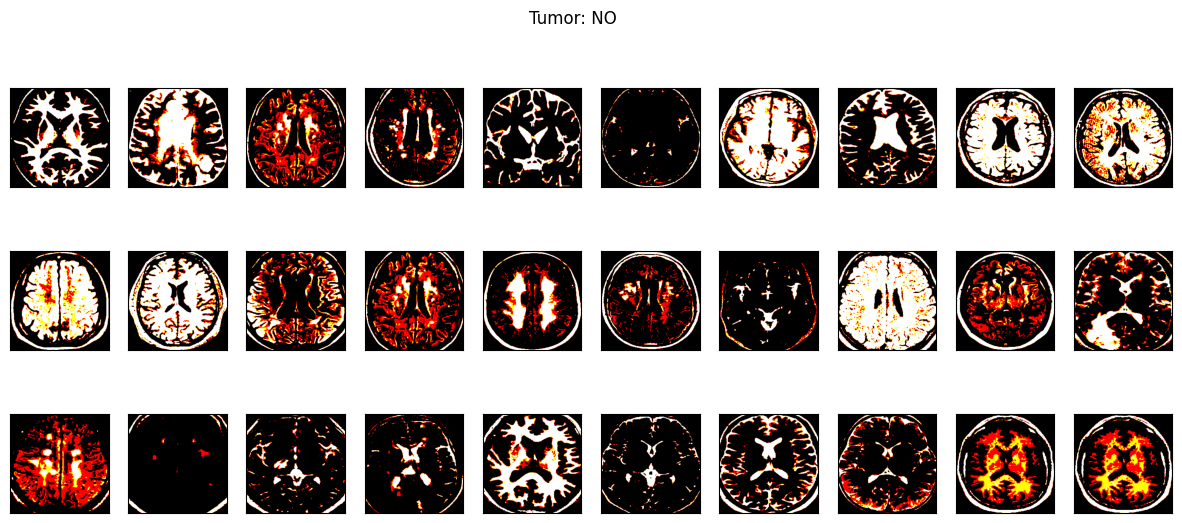

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-111.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.68..150.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-121.68..145.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data 

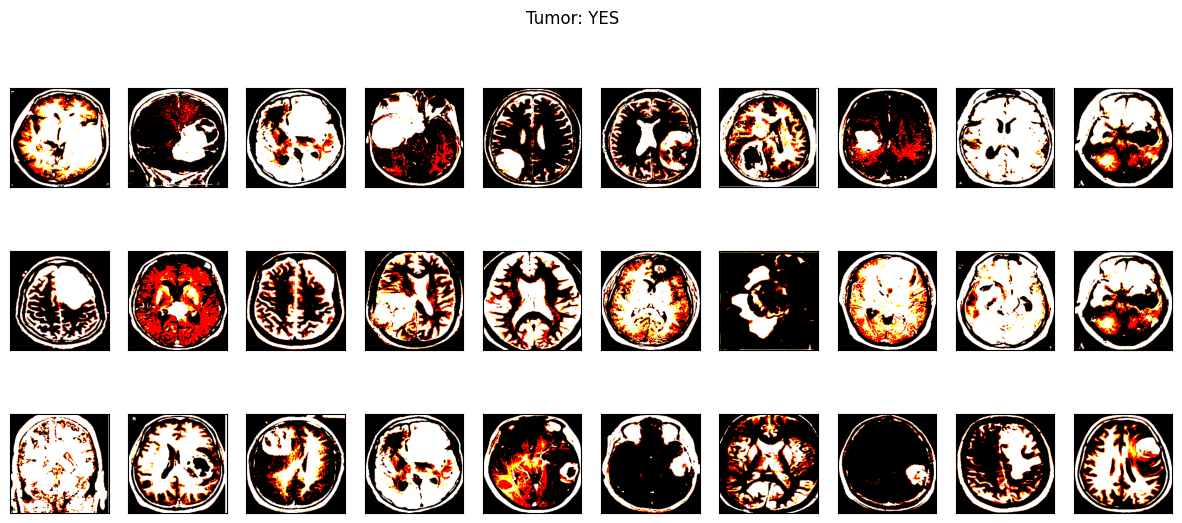

In [38]:
plot_samples(X_train_prep, y_train, labels, 30)